In [2]:
#simple linear model
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [3]:
tf.__version__

'1.6.0'

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data=input_data.read_data_sets("data/MNIST/",one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
print("Size of:")
print("Training-set:\t\t{}".format(len(data.train.labels)))
print("test set:\t\t{}".format(len(data.test.labels)))
print("validation set:\t\t{}".format(len(data.validation.labels)))

Size of:
Training-set:		55000
test set:		10000
validation set:		5000


In [6]:
data.test.labels[0:5,]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [7]:
data.test.cls=np.array([label.argmax() for label in data.test.labels])

In [8]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

In [10]:
#data dimension
img_size=28
img_size_flat=img_size*img_size
img_shape=(img_size,img_size)
num_classes=10

In [14]:
#helper function for plotting image
def plot_images(images, cls_true, cls_pred=None):
    assert len(images)==len(cls_true)==9
    #create figure with 3*3 sub-plot
    fig,axes=plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        #show true and predicted class 
        if cls_pred is None:
            xlabel= "True: {0}".format(cls_true[i])
        else:
            xlabel= "True: {0}, Pred: {1}".format(cls_true[i],cls_pred[i])
        ax.set_xlabel(xlabel)
        #remove tick from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

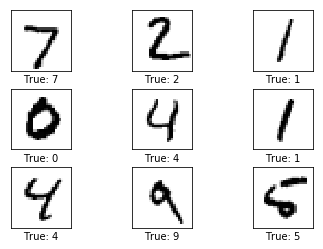

In [15]:
#plot some images from dataset
images=data.test.images[0:9]
cls_true =data.test.cls[0:9]
plot_images(images=images,cls_true=cls_true)

In [16]:
x=tf.placeholder(tf.float32,[None,img_size_flat])
y_true=tf.placeholder(tf.float32,[None,num_classes])

In [17]:
y_true_cls=tf.placeholder(tf.int64,[None])

In [18]:
#variable to be optimized
weights=tf.Variable(tf.zeros([img_size_flat,num_classes]))

In [19]:
biases=tf.Variable(tf.zeros([num_classes]))

In [20]:
#model
logits=tf.matmul(x,weights)+biases

In [21]:
y_pred=tf.nn.softmax(logits)

In [22]:
y_pred_cls=tf.argmax(y_pred,axis=1)

In [23]:
cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [24]:
cost=tf.reduce_mean(cross_entropy)

In [25]:
#optimization method
optimizer =tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [27]:
#performance measure
correct_prediction=tf.equal(y_pred_cls,y_true_cls)

In [28]:
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [29]:
#create tensorflow session
session=tf.Session()


In [32]:
#initialize variable
session.run(tf.global_variables_initializer())

In [33]:
batch_size=100

In [35]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch,y_true_batch=data.train.next_batch(batch_size)
        feed_dict_train={x:x_batch,y_true:y_true_batch}
        session.run(optimizer,feed_dict=feed_dict_train)

In [44]:
#helper function to shoe performance 
feed_dict_test = {x:data.test.images,
                   y_true: data.test.labels,
                   y_true_cls:data.test.cls}

In [45]:
def print_accuracy():
    acc=session.run(accuracy,feed_dict=feed_dict_test)
    print("Accuracy on test set: {0:.1%}".format(acc))

In [75]:
def print_confusion_matrix():
    cls_true=data.test.cls
    cls_pred=session.run(y_pred_cls,feed_dict=feed_dict_test)
    cm=confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    print(cm)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks=np.arange(num_classes)
    plt.xticks(tick_marks,range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [76]:
def plot_example_errors():
    correct,cls_pred=session.run([correct_prediction,y_pred_cls],feed_dict=feed_dict_test)
    incorrect=(correct==False)
    images=data.test.images[incorrect]
    cls_pred=cls_pred[incorrect]
    cls_true=data.test.cls[incorrect]
    plot_images(images=images[0:9],cls_true=cls_true[0:9],cls_pred=cls_pred[0:9])

In [77]:
#helper function to plot model weight
def plot_weights():
    w=session.run(weights)
    w_min=np.min(w)
    w_max=np.max(w)
    fig,axes=plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i,ax in enumerate(axes.flat):
        if i<10:
            image=w[:,i].reshape(img_shape)
            ax.set_xlabel("weights: {0}".format(1))
            ax.imshow(image,vmin=w_min,vmax=w_max,cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [78]:
print_accuracy()

Accuracy on test set: 91.8%


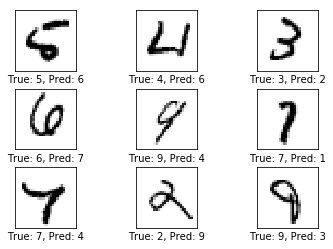

In [79]:
plot_example_errors()

In [80]:
optimize(num_iterations=1)

In [81]:
print_accuracy()

Accuracy on test set: 91.9%


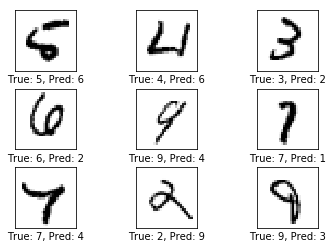

In [82]:
plot_example_errors()

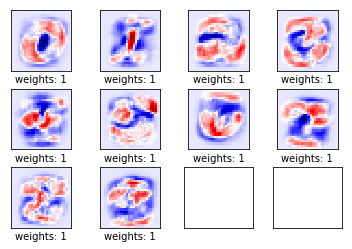

In [83]:
plot_weights()

In [84]:
optimize(num_iterations=9)

In [85]:
print_accuracy()

Accuracy on test set: 91.9%


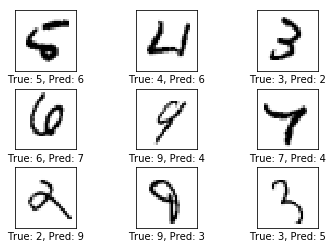

In [86]:
plot_example_errors()

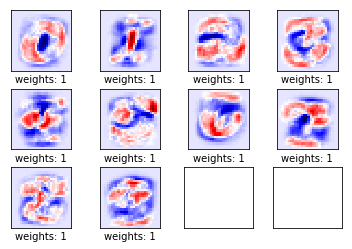

In [87]:
plot_weights()

In [88]:
optimize(num_iterations=990)

In [89]:
print_accuracy()

Accuracy on test set: 92.0%


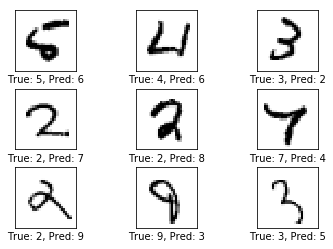

In [90]:
plot_example_errors()

[[ 957    0    1    2    0    5   11    1    3    0]
 [   0 1105    2    2    0    1    4    2   19    0]
 [  10   10  891   16    4    5   19   12   56    9]
 [   4    0   15  903    0   37    4   10   29    8]
 [   1    2    4    2  894    1   15    3   12   48]
 [  10    1    1   27    7  776   18    5   40    7]
 [  10    3    2    2    7   11  917    2    4    0]
 [   3    6   17   10    6    1    0  947    6   32]
 [   4    4    4   16    7   23   11    9  890    6]
 [   9    5    1    7   22    7    1   26   14  917]]


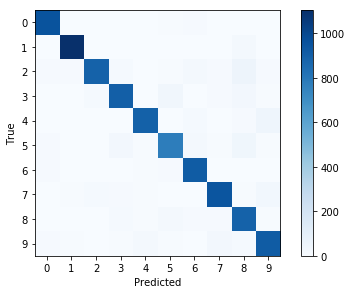

In [91]:
print_confusion_matrix()